# Brief example as shown in the main README

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt

from MSA_Pairformer.model import MSAPairformer
from MSA_Pairformer.dataset import MSA, prepare_msa_masks, onehot_msa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load MSA Pairformer model

In [4]:
# Use the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {torch.cuda.get_device_name(device)}")

# # This function will allow you to login to huggingface via an API key
# login()

# Download model weights and load model
# As long as the cache doesn't get cleared, you won't need to re-download the weights whenever you re-run this
model = MSAPairformer.from_pretrained(device=device)

Using device: NVIDIA GH200 480GB


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 76818.75it/s]


## Generate embeddings and predict contacts

In [ ]:
# Load example MSA
nSeqs = 512
chain_break_idx = 311
msa_path = "../data/complexes/1EFP_A_1EFP_B.fas"
with open(msa_path, "r") as oFile:
    total_length = len(oFile.readlines()[1].strip())
np.random.seed(42)
msa_obj = MSA(
    msa_file_path = msa_path,
    max_seqs = nSeqs,
    max_length = total_length,
    max_tokens = 1e12,
    diverse_select_method = "hhfilter",
)
msa_tokenized_t = msa_obj.diverse_tokenized_msa
msa_onehot_t = onehot_msa(msa_tokenized_t, device=device).unsqueeze(0).float().to(device)
chain_break_indices = [[chain_break_idx]]
mask, msa_mask, full_mask, pairwise_mask = prepare_msa_masks(msa_obj.diverse_tokenized_msa.unsqueeze(0), device=device)
with torch.no_grad():
    res = model(
        msa = msa_onehot_t,
        mask = mask,
        msa_mask = msa_mask,
        full_mask = full_mask,
        pairwise_mask = pairwise_mask,
        complex_chain_break_indices = chain_break_indices,
    )

## Predict residue-residue interactions at the interface of hetero-oligomeric complexes

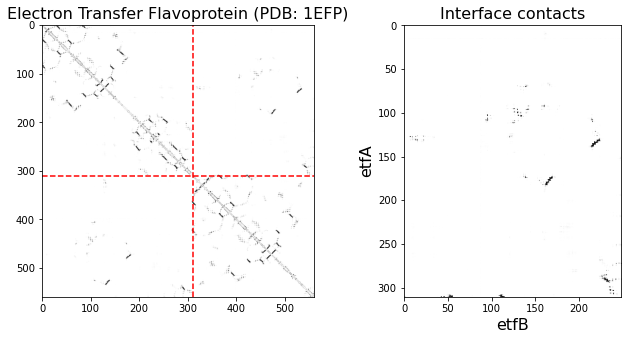

In [43]:
# Load example MSA
nSeqs = 512
chain_break_idx = 308
msa_path = "../data/complexes/1EFP_A_1EFP_B.fas"
with open(msa_path, "r") as oFile:
    total_length = len(oFile.readlines()[1].strip())
np.random.seed(42)
msa_obj = MSA(
    msa_file_path = msa_path,
    max_seqs = nSeqs,
    max_length = total_length,
    max_tokens = 1e12,
    diverse_select_method = "hhfilter",
)
msa_tokenized_t = msa_obj.diverse_tokenized_msa
msa_onehot_t = torch.nn.functional.one_hot(msa_tokenized_t, num_classes=len(aa2tok_d)).unsqueeze(0).float().to(device)
chain_break_indices = [[chain_break_idx]]
mask, msa_mask, full_mask, pairwise_mask = prepare_msa_masks(msa_obj.diverse_tokenized_msa.unsqueeze(0))
mask, msa_mask, full_mask, pairwise_mask = mask.to(device), msa_mask.to(device), full_mask.to(device), pairwise_mask.to(device)
with torch.no_grad():
    pred_contacts = model.predict_contacts(
        msa = msa_onehot_t,
        mask = mask,
        msa_mask = msa_mask,
        full_mask = full_mask,
        pairwise_mask = pairwise_mask,
        complex_chain_break_indices = chain_break_indices,
    )
# Plot contact map
f, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].imshow(pred_contacts[0].cpu().numpy(), cmap='Greys')
ax[0].axhline(y=chain_break_idx, color='r', linestyle='--')
ax[0].axvline(x=chain_break_idx, color='r', linestyle='--')
ax[0].set_title('Electron Transfer Flavoprotein (PDB: 1EFP)', size=16)
ax[1].imshow(pred_contacts[0].cpu().numpy()[:chain_break_idx, chain_break_idx:], cmap='Greys')
ax[1].set_title("Interface contacts", size=16)
ax[1].set_xlabel("etfB", size=16)
ax[1].set_ylabel("etfA", size=16)
f.subplots_adjust(wspace=0)
plt.show()

# Variant effect prediction